# Summary
*David Thomas 2017/01/22*

In this notebook I generate mock luminosity data and then a mock Q distribution, where Q is an importance sampling distribution over (M,L).

# Load Data

In [2]:
import pandas as pd
from massinference.angle import Angle

# opening, white-listing, renaming
usecols = ['GalID', 'pos_0[rad]', 'pos_1[rad]', 'M_Subhalo[M_sol/h]', 'z_spec']
guo = pd.read_table(
    '/Users/user/Code/Pangloss/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt', 
    usecols=usecols)
guo.rename(
    columns={'GalID': 'gal_id',
             'M_Subhalo[M_sol/h]': 'mass_h',
             'z_spec': 'z'
            }, 
    inplace=True)
guo = guo[guo['mass_h'] > 0]

guo['mass_h'] = guo['mass_h'] * 0.73 #remove h^{-1} from mass units, use h from WMAP

# convert to arcmin
guo['ra'] = Angle.radian_to_arcmin(guo['pos_0[rad]'])
guo['dec'] = Angle.radian_to_arcmin(guo['pos_1[rad]'])

# field of view bounds
ra_i = guo['ra'].min()
dec_i = guo['dec'].min()
ra_f = ra_i + 40
dec_f = dec_i + 40
z_i = guo['z'].min()
z_f = guo['z'].max()

# clip data, fov = field of view
fov = guo[(guo['ra'] >= ra_i)
           & (guo['ra'] < ra_f)
           & (guo['dec'] >= dec_i)
           & (guo['dec'] < dec_f)].copy(deep=True)

fov.drop(['pos_0[rad]', 'pos_1[rad]'], axis=1, inplace=True)

# Generate Mock Observed Luminosity

In [42]:
import numpy as np

# original values
# sigma_L = 1
# a1 = 12
# a2 = 1.4
# a3 = fov['mass_h'].min() 
# a4 = 10
# sigma_obs = 2

S = 0.155
a1 = 10.709
a2 = 0.359
a3 = 2.35e14
a4 = 1.10
sigma_obs = 0.01

mean_L = a1 + a2*np.log(fov['mass_h'] / a3) + a4 * np.log(1 + fov['z'])
fov['lum'] = np.random.lognormal(mean_L, S, len(fov))
fov['lum_obs'] = np.random.lognormal(np.log(fov['lum']), sigma_obs, len(fov))

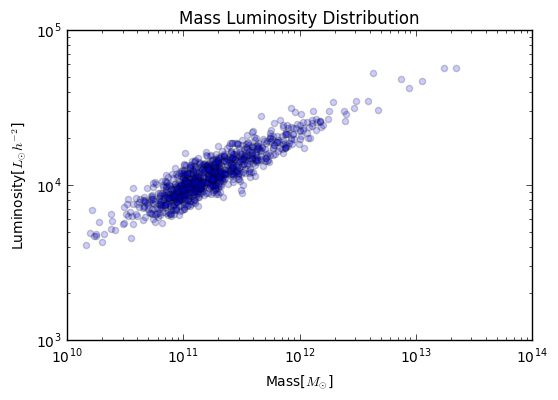

In [43]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.scatter(fov[:1000]['mass_h'], fov[:1000]['lum_obs'], alpha=0.2)
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposx='clip')
plt.title('Mass Luminosity Distribution')
plt.xlabel('Mass[$M_{\odot}$]')
plt.ylabel('Luminosity[$L_{\odot}h^{-2}$]')

# Generate Q

In [56]:
fov['q_lum'] = np.random.lognormal(np.log(fov['lum_obs']), sigma_obs, len(fov))
fov['q_mass_h_mean'] = a3 * (fov['q_lum'] / (np.exp(a1) * (1+fov['z']) ** a4 )) ** (1 / a2)
fov['q_mass_h'] = np.random.lognormal(np.log(fov['q_mass_h_mean']), 5*S, len(fov))

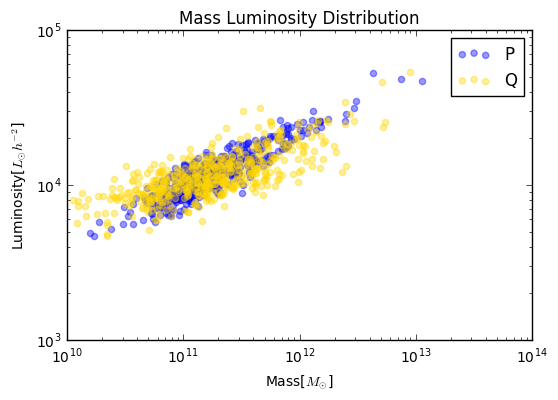

In [57]:
plt.scatter(fov[:500]['mass_h'], fov[:500]['lum_obs'], alpha=0.4, color='blue', label='P')
plt.scatter(fov[:500]['q_mass_h'], fov[:500]['q_lum'], alpha=0.4, color='gold', label='Q')
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposx='clip')
plt.title('Mass Luminosity Distribution')
plt.xlabel('Mass[$M_{\odot}$]')
plt.ylabel('Luminosity[$L_{\odot}h^{-2}$]')
plt.legend()